In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torchvision.datasets as dst
import torch.optim as optim
import numpy as np
from skimage import io
from skimage import transform
import matplotlib.pyplot as plt
import os
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from torchvision.utils import make_grid

In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import librosa.display
import seaborn as sns

In [ ]:
import seaborn as sns
sns.set()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
n_fft=2048
hop_length=512
class MyDataset(Dataset):

    def __init__(self, root_dir, names_file, transform=None):
        self.root_dir = root_dir
        self.names_file = names_file
        self.transform = transform
        self.size = 0
        self.names_list = []

        if not os.path.isfile(self.names_file):
            print(self.names_file + ' does not exist!!!')
        file = open(self.names_file)
        for f in file:
            self.names_list.append(f)
            self.size += 1

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        music_path = self.root_dir + self.names_list[idx].split(' ')[0]
        if not os.path.isfile(music_path):
            print(music_path + ' does not exist!')
            return None

        y, sr = librosa.load(music_path)
        spectrogram_librosa = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=n_fft, window='hann')) ** 2
        spectrogram_librosa_db = librosa.power_to_db(spectrogram_librosa, ref=np.max)

        music = spectrogram_librosa_db 
        label = int(self.names_list[idx].split(' ')[1])

        sample = {'music': music, 'label': label}
        if self.transform:
            sample = self.transform(sample)

        return sample

In [ ]:
train_dataset = MyDataset(root_dir='/content/drive/My Drive/Datasets/Medley solos db/train/',
                          names_file='/content/drive/My Drive/Datasets/Medley solos db/train/train.txt',
                          transform=None)

test_dataset = MyDataset(root_dir='/content/drive/My Drive/Datasets/Medley solos db/test/',
                          names_file='/content/drive/My Drive/Datasets/Medley solos db/test/test.txt',
                          transform=None)

validation_dataset = MyDataset(root_dir='/content/drive/My Drive/Datasets/Medley solos db/val/',
                          names_file='/content/drive/My Drive/Datasets/Medley solos db/val/val.txt',
                          transform=None)

In [ ]:
train_dataset.__getitem__(0)['music'].shape

(1025, 129)

In [ ]:
class ToTensor(object):
    def __call__(self, sample):
        music = sample['music']
        return {'music': torch.from_numpy(music),
                'label': sample['label']}

In [ ]:
class Resize(object):

    def __init__(self, output_size: tuple):
        self.output_size = output_size

    def __call__(self, sample):
        music = sample['music']
        music_new = transform.resize(music, self.output_size)
        return {'music': music_new, 'label': sample['label']}

In [ ]:
transformed_trainset = MyDataset(root_dir='/content/drive/My Drive/Datasets/Medley solos db/train/',
                          names_file='/content/drive/My Drive/Datasets/Medley solos db/train/train.txt',
                          transform=ToTensor()
                          )


transformed_testset = MyDataset(root_dir='/content/drive/My Drive/Datasets/Medley solos db/test/',
                          names_file='/content/drive/My Drive/Datasets/Medley solos db/test/test.txt',
                          transform=ToTensor()
                          )

transformed_validationset = MyDataset(root_dir='/content/drive/My Drive/Datasets/Medley solos db/val/',
                          names_file='/content/drive/My Drive/Datasets/Medley solos db/val/val.txt',
                          transform=ToTensor()
                          )

In [ ]:
EPOCH = 100
BATCH_SIZE = 32
n = 4   # num_workers
LATENT_CODE_NUM = 32      
log_interval = 10

In [ ]:
trainset_dataloader = DataLoader(dataset=transformed_trainset,
                                 batch_size=BATCH_SIZE,
                                 shuffle=True,
                                 num_workers=n)

testset_dataloader = DataLoader(dataset=transformed_testset,
                                 batch_size=BATCH_SIZE,
                                 shuffle=True,
                                 num_workers=n)

validationset_dataloader = DataLoader(dataset=transformed_validationset,
                                 batch_size=BATCH_SIZE,
                                 shuffle=True,
                                 num_workers=n)

In [ ]:
def loss_function(recon_x, x, mu, logvar):
    """
    :param recon_x: generated image
    :param x: original image
    :param mu: latent mean of z
    :param logvar: latent log variance of z
    """
    # BCE_loss = nn.BCELoss(reduction='sum')
    MSE_loss = torch.nn.MSELoss(reduction = 'sum')
    # reconstruction_loss = BCE_loss(recon_x, x)
    reconstruction_loss = MSE_loss(recon_x, x)
    
    KL_divergence = -0.5 * torch.sum(1+logvar-torch.exp(logvar)-mu**2)
#     print(reconstruction_loss, KL_divergence)

    return reconstruction_loss + KL_divergence

In [ ]:
 class VAE(nn.Module):
      def __init__(self):
          super(VAE, self).__init__()
        
          self.encoder = nn.Sequential(
              nn.Conv2d(1, 64, kernel_size=(1,3), stride=2, padding=1),    # kernal size was 4, , stride=2, padding=1
              nn.BatchNorm2d(64),
              nn.LeakyReLU(0.2, inplace=True),
        
              nn.Conv2d(64, 128, kernel_size=(1,3), stride=2, padding=1),  # stride=2, padding=1
              nn.BatchNorm2d(128),
              nn.LeakyReLU(0.2, inplace=True),
                        
              nn.Conv2d(128, 128, kernel_size=(1,3) ,stride=1, padding=1), # stride=1, padding=1
              nn.BatchNorm2d(128),
              nn.LeakyReLU(0.2, inplace=True), 
              )
       
          self.fc11 = nn.Linear(128*260*33, LATENT_CODE_NUM)    # was 512
          self.fc12 = nn.Linear(128*260*33, LATENT_CODE_NUM)
          self.fc2 = nn.Linear(LATENT_CODE_NUM, 128*514*65)


          self.decoder = nn.Sequential(
                nn.ConvTranspose2d(128, 32, kernel_size=(1,3), stride=2, padding=1),  # stride=2, padding=1
                nn.ReLU(inplace=True),
                nn.Conv2d(32, 1, kernel_size=(3, 3), stride=1, padding=1),   # stride=2, padding=1
                nn.ReLU(inplace=True)
          )
            
          self.c1 = nn.Sequential(
              nn.Conv2d(128, 32, kernel_size=(1,3), stride=2, padding=1),
              nn.ReLU(inplace=True),
              nn.MaxPool2d(2, 2),
              nn.Conv2d(32, 1, kernel_size=(1,3), stride=2, padding=1),
              nn.ReLU(inplace=True)
          )
        
          self.c2 = nn.Sequential(
              nn.Linear(66 * 8, 120),
              nn.ReLU(inplace=True),
              nn.Linear(120, 84),
              nn.ReLU(inplace=True),
              nn.Linear(84, 5),
              nn.ReLU(inplace=True),
              nn.Softmax(0)
          )
          
      def reparameterize(self, mu, logvar):
        eps = Variable(torch.randn(mu.size(0), mu.size(1))).cuda()
        z = mu + eps * torch.exp(logvar/2)
        return z
        
      def forward(self, x):
        out1, out2 = self.encoder(x), self.encoder(x)
        mu = self.fc11(out1.view(out1.size(0),-1))     # batch_s, latent
        logvar = self.fc12(out2.view(out2.size(0),-1)) # batch_s, latent
        z = self.reparameterize(mu, logvar)      # batch_s, latent
        
        out3 = self.fc2(z).view(z.size(0), 128, 514, -1)    # batch_s, 8, 7, 7
        out4 = self.c1(out3).view(out3.size(0), -1)
        return self.decoder(out3), mu, logvar, self.c2(out4)

In [ ]:
vae = VAE().cuda()
# optimizer = optim.Adam(vae.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
best_loss_recon = 1e8 #保存最佳重构结果
best_loss_clf = 1e8 #保存最佳分类结果

In [ ]:
def test(model):
    # vae.eval()
    model.eval()
    total_loss = 0.0
    clf_loss = 0.0
    cot = 0
    for i_batch, sample_batch in enumerate(testset_dataloader):
      data = Variable(torch.unsqueeze(sample_batch['music'], dim=1).float()).cuda()
#       print("data size:", data.shape)

      with torch.no_grad():
        recon_x, mu, logvar, clf_x = model.forward(data)#edited, was vae.foward(data)
        recon_x = torch.clamp(recon_x, 0, 1)
        
      loss = loss_function(recon_x, data, mu, logvar)
      label = Variable(torch.LongTensor(sample_batch['label'])).cuda()
      criterion = nn.CrossEntropyLoss()
      loss_clf = criterion(clf_x, label)
      clf_loss += loss_clf.item()
      total_loss += loss.item()
      hep,temp=torch.topk(clf_x, 1)
      # print("temp is :", temp)
      # print("label is :", label)
      if temp==label:
        cot+=1
      print("current cot is: ", cot)

    print('====> Test: {}\nReconstruction loss: {:.4f}\nClassification loss: {:.4f}'.format(
        epoch, total_loss / len(testset_dataloader.dataset), clf_loss / len(testset_dataloader.dataset)))
    print('Classification accuracy: ', cot/len(testset_dataloader.dataset))
    # print("end of testing")

In [ ]:
def val():
    global rec_val 
    vae.eval()
    total_loss = 0.0
    clf_loss = 0.0
    for i_batch, sample_batch in enumerate(validationset_dataloader):
      data = Variable(torch.unsqueeze(sample_batch['music'], dim=1).float()).cuda()
#       print("data size:", data.shape)

      with torch.no_grad():
        recon_x, mu, logvar, clf_x = vae.forward(data)#edited, was vae.foward(data)
        recon_x = torch.clamp(recon_x, 0, 1)
        
      loss = loss_function(recon_x, data, mu, logvar)
      label = Variable(torch.LongTensor(sample_batch['label'])).cuda()
      criterion = nn.CrossEntropyLoss()
      loss_clf = criterion(clf_x, label)
      clf_loss += loss_clf.item()
      total_loss += loss.item()
      
      if total_loss < best_loss_recon and clf_loss < best_loss_clf:
            best_loss_recon, best_loss_clf = total_loss, clf_loss
            torch.save(vae, 'model.pth')
            
    rec_val.append((total_loss / len(trainset_dataloader.dataset), (clf_loss / len(trainset_dataloader.dataset))))
    print('====> Val: {}\nReconstruction loss: {:.4f}\nClassification loss: {:.4f}'.format(
        epoch, total_loss / len(validationset_dataloader.dataset), clf_loss / len(validationset_dataloader.dataset)))
    # print("end of testing")

In [ ]:
def train(EPOCH):
    global rec_recon, rec_clf
    
    vae.train()
    total_loss = 0.0
    clf_loss = 0.0
    for i_batch, sample_batch in enumerate(trainset_dataloader):
      data = Variable(torch.unsqueeze(sample_batch['music'], dim=1).float()).cuda()
#     print("data size:", data.shape)
      optimizer.zero_grad()
      recon_x, mu, logvar, clf_x = vae.forward(data)
      recon_x = torch.clamp(recon_x, 0, 1)
      loss = loss_function(recon_x, data, mu, logvar)
      loss.backward(retain_graph=True)
      label = Variable(torch.LongTensor(sample_batch['label'])).cuda()
      criterion = nn.CrossEntropyLoss()
      loss_clf = criterion(clf_x, label)
      loss_clf.backward()
      clf_loss += loss_clf.item()
      total_loss += loss.item()
      optimizer.step()
    
    rec_recon.append(total_loss / len(trainset_dataloader.dataset))
    rec_clf.append(clf_loss / len(trainset_dataloader.dataset))

    print('====> Epoch: {}\nReconstruction loss: {:.4f}\nClassification loss: {:.4f}'.format(
        epoch, total_loss / len(trainset_dataloader.dataset), clf_loss / len(trainset_dataloader.dataset)))
    # print("end of training")

In [ ]:
global rec_recon, rec_clf, rec_val
rec_recon, rec_cl,rec_val = [], [], []

learning_rate = 0.00001

for epoch in range(EPOCH):
    optimizer = optim.Adam(vae.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
    train(epoch)
    val()
    if len(rec_val) >=2 and rec_val[-1] > rec_val[-2]:
      learning_rate*= 0.5


plt.title('Reconstruction Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(range(EPOCH), rec_recon, color='r') #绘制重构loss
plt.savefig('Lossplot1.png')
plt.show()

plt.title('Classification Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(range(EPOCH),rec_clf,color='r') #绘制分类loss
plt.savefig('Lossplot2.png')
plt.show()


test(vae)

## **---------------------------Division Line---------------------------------**

In [ ]:
# from torchviz import make_dot, make_dot_from_trace
# import graphviz

# x = torch.randn(1, 1, 1025, 129).cuda() #生成随机的张量输入
# vae = vae.cuda()

# vis_graph = make_dot(vae(x), params=dict(vae.named_parameters()))
# vis_graph.view()



# out1, a, b, out2 = vae(x)
# print('reconstruct result: 'out1) #输出重构后的矩阵
# v, idx = torch.topk(out2, 1)
# print('classify label', idx) #输出分类的结果

In [ ]:
# summary(vae,(1,1025,129))

In [ ]:
ModelPath = '/content/drive/My Drive/Models/model.pth'
tempNet = VAE()
tempNet = torch.load(ModelPath)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:615: UserWarning: Couldn't retrieve source code for container of type VAE. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)

In [ ]:
test(tempNet)

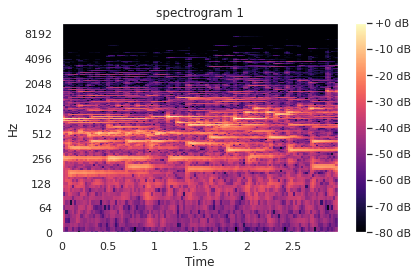

In [ ]:
n_fft=2048
hop_length=512

audio_path = '/content/Medley-solos-DB_test-4_0a75f8d2-eca8-5422-f46a-0f39ddb6570f.wav'
y , sr = librosa.load(audio_path)
spectrogram_librosa = np.abs(librosa.stft(
    y, n_fft=n_fft, hop_length=hop_length, win_length=n_fft, window='hann')) ** 2

spectrogram_librosa_db = librosa.power_to_db(spectrogram_librosa, ref=np.max)

librosa.display.specshow(spectrogram_librosa_db, sr=sr, y_axis='log', x_axis='time', hop_length=hop_length)
plt.title('spectrogram 1')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

In [ ]:
x=torch.from_numpy(spectrogram_librosa_db)
print(x.shape)


x=torch.unsqueeze(x, dim=0)
x=torch.unsqueeze(x, dim=1)
print(x.shape)
x = x.cuda()

torch.Size([1025, 129])
torch.Size([1, 1, 1025, 129])


In [ ]:
out1, a, b, out2 = tempNet(x)
print('reconstruct result:',out1) #输出重构后的矩阵
v, idx = torch.topk(out2, 1)
print('classify label', idx) #输出分类的结果

reconstruct result: tensor([[[[0.0515, 0.1799, 0.0640,  ..., 0.0774, 0.0569, 0.1091],
          [0.0252, 0.4704, 0.4740,  ..., 0.3553, 0.5561, 0.1300],
          [0.0000, 0.0000, 0.3148,  ..., 0.0329, 0.1574, 0.5903],
          ...,
          [0.1105, 0.0613, 0.1442,  ..., 0.4812, 0.0971, 0.0258],
          [0.2834, 0.3088, 0.0000,  ..., 0.2524, 0.1653, 0.0307],
          [0.2977, 0.0000, 0.1377,  ..., 0.2410, 0.3893, 0.1556]]]],
       device='cuda:0', grad_fn=<ReluBackward1>)
classify label tensor([[2]], device='cuda:0')
shape: torch.Size([1, 1, 1025, 129])


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [ ]:
out1=torch.squeeze(out1, dim=0)
print("shape:", out1.shape)
out1=torch.squeeze(out1, dim=0)
print("shape:", out1.shape)
out1 = out1.cpu().detach()
output = np.array(out1)
print(output)

shape: torch.Size([1025, 129])
shape: torch.Size([1025, 129])
[[0.05151609 0.17988375 0.06398539 ... 0.07739355 0.05687562 0.10909287]
 [0.02515531 0.47038704 0.47395527 ... 0.35534233 0.5561344  0.12997428]
 [0.         0.         0.3147764  ... 0.03287663 0.15742064 0.59030306]
 ...
 [0.11054205 0.06129636 0.1441747  ... 0.481236   0.09711667 0.02575968]
 [0.28336668 0.30876842 0.         ... 0.25238153 0.16530132 0.03065777]
 [0.29773015 0.         0.13769805 ... 0.24104723 0.38934565 0.15558429]]


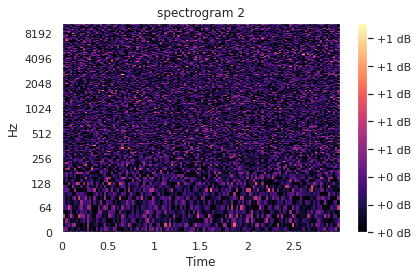

In [ ]:
librosa.display.specshow(output, sr=sr, y_axis='log', x_axis='time', hop_length=hop_length)
plt.title('spectrogram 2')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

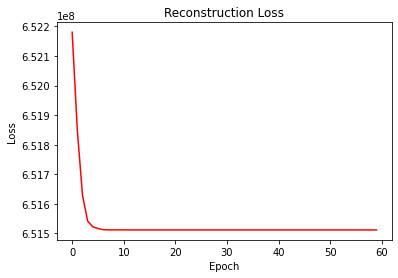

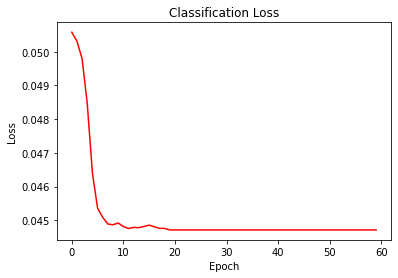

In [ ]:
EPOCH = 60

aaa  = [652180350.7189752, 651849497.7742194, 651629647.8334668, 651541907.2153723, 651522718.8983186, 651516763.6188952, 651512987.2089672, 651512201.0696558, 651512211.3690953, 651512254.4115292, 651512102.3795036, 651512093.0536429, 651512088.0832666, 651512093.8222578, 651512089.0056045, 651512090.2353883, 651512084.957566, 651512086.6997598, 651512089.5180144, 651512087.3146517, 651512089.5180144, 651512090.2866293, 651512088.8518815, 651512091.6701361, 651512089.0056045, 651512087.0072057, 651512088.3394716, 651512086.8022418, 651512092.2337871, 651512089.3642914, 651512089.1593275, 651512087.5196157, 651512087.6220977, 651512092.541233, 651512093.2586069, 651512089.5180144, 651512093.3610889, 651512089.3642914, 651512089.2105684, 651512092.285028, 651512095.0520416, 651512088.3394716, 651512089.0568454, 651512089.0568454, 651512085.777422, 651512087.8783027, 651512085.7261809, 651512086.8534828, 651512088.9031225, 651512085.0088071, 651512097.6140913, 651512088.1345077, 651512091.5676541, 651512089.7742194, 651512091.772618, 651512087.5196157, 651512090.7477982, 651512090.1841474, 651512092.285028, 651512090.4915932]
bbb = [0.05057679712056541, 0.05031272353793832, 0.04978873011014097, 0.04845768898081264, 0.0463966576455592, 0.04535476239420491, 0.04508399777263522, 0.04488659320209769, 0.04486629743877652, 0.04491830349350281, 0.0448123018583171, 0.044754662090916934, 0.04478804694355918, 0.04477953249879414, 0.04481564506327657, 0.04485444496687743, 0.04480574744715511, 0.044759545830176106, 0.044756781181590474, 0.04471263828708994,0.044712624808893014, 0.04471260654266981, 0.04471262395903751, 0.04471262116002653, 0.044712609354808135, 0.04471261270525697, 0.044712609433765586, 0.044712615441139074, 0.044712616344959696, 0.04471260092486186, 0.04471261460653364, 0.044712633658695475, 0.0447126171492666, 0.04471262509688456, 0.04471263186255781, 0.04471260437692554, 0.04471260037269193, 0.04471261976853718, 0.04471261200418519, 0.04471261336426531, 0.044712600230097224, 0.04471263163108541, 0.044712606154557986, 0.04471263137781364, 0.044712635549046156, 0.04471262890558242, 0.04471263059216732, 0.04471263448786252, 0.04471263380317062, 0.04471262759903766, 0.04471261178369011, 0.044712609358819384, 0.04471260887514945, 0.04471260747837784, 0.04471261973051455, 0.0447126354202109, 0.044712618679698994, 0.044712614812238045, 0.04471261525047231, 0.04471262723783836 ]
plt.title('Reconstruction Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(range(EPOCH), aaa, color='r') #绘制重构loss
plt.savefig('Lossplot1.png')
plt.show()

plt.title('Classification Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(range(EPOCH), bbb ,color='r') #绘制分类loss
plt.savefig('Lossplot2.png')
plt.show()
